In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [2]:
%matplotlib notebook

In [3]:
class PPO_0(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=40, pi_lr=5e-5, v_lr=5e-4):

        super().__init__()
        
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh()).to(self.device)
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1)).to(self.device)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state, rand_factor = 1):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, rand_factor*torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        states, actions, returns = states.to(self.device), actions.to(self.device), returns.to(self.device)

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [4]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO_0(state_dim, action_dim)

total_rewards = []

C:\Users\boh-b\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [5]:
%%time

episode_n = 30
trajectory_n = 30

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []
    
    agent.pi_model.to('cpu')
    agent.v_model.to('cpu')
    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)
    agent.pi_model.to(agent.device)
    agent.v_model.to(agent.device)
    agent.fit(states, actions, rewards, dones)
    
    print(episode,total_reward,end='\r')

CPU times: total: 14min 10s
Wall time: 4min 5s


In [6]:
total_rewards_1 = total_rewards.copy()

<IPython.core.display.Javascript object>


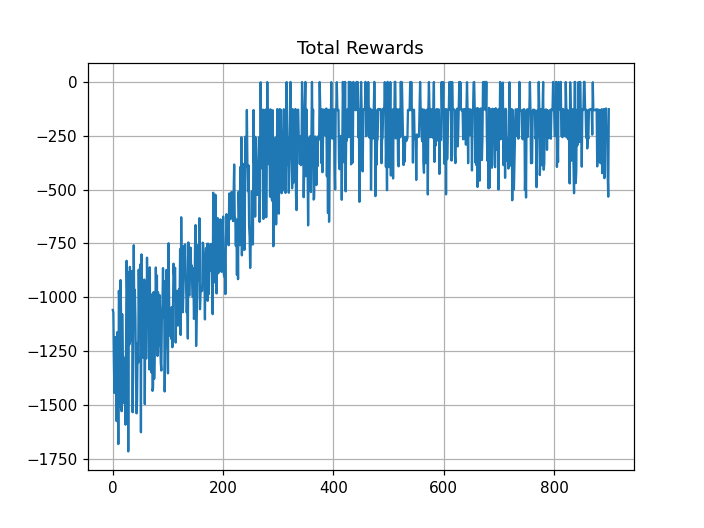

In [7]:
plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()

cuda_1_impl:
CPU times: total: 29.9 s
Wall time: 2min 45s

cpu_cuda_code_1_impl:
CPU times: total: 2min 36s
Wall time: 1min 5s

cpu_original:
CPU times: total: 2min 29s
Wall time: 1min 6s

cuda_2_impl:
CPU times: total: 45.9 s
Wall time: 2min 23s

cpu_cuda_code_2_impl:
CPU times: total: 2min 47s
Wall time: 1min 5s

In [67]:
state = env.reset()
total_reward = 0
for t in range(200):
    states.append(state)
    action = agent.get_action(state,1)
    actions.append(action)

    state, reward, done, _ = env.step(2 * action)
    rewards.append(reward)
    dones.append(done)
    env.render()
    total_reward += reward
print(total_reward)

-373.6231853990811


In [8]:
class PPO_1(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=40, pi_lr=5e-5, v_lr=5e-4):

        super().__init__()
        
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh()).to(self.device)
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1)).to(self.device)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state, rand_factor = 1):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, rand_factor*torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)
        v_values = self.v_model(torch.FloatTensor(states)).detach().numpy()
        
        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * v_values[t + 1][0]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        states, actions, returns = states.to(self.device), actions.to(self.device), returns.to(self.device)

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [9]:
%%time

env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO_1(state_dim, action_dim)

episode_n = 30
trajectory_n = 30

total_rewards = []

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []
    
    agent.pi_model.to('cpu')
    agent.v_model.to('cpu')
    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(2 * action)
            
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)
    agent.pi_model.to(agent.device)
    agent.v_model.to(agent.device)
    agent.fit(states, actions, rewards, dones)
    
    print(episode,total_reward,end='\r')

C:\Users\boh-b\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


CPU times: total: 15min 20s
Wall time: 4min 10s


<IPython.core.display.Javascript object>


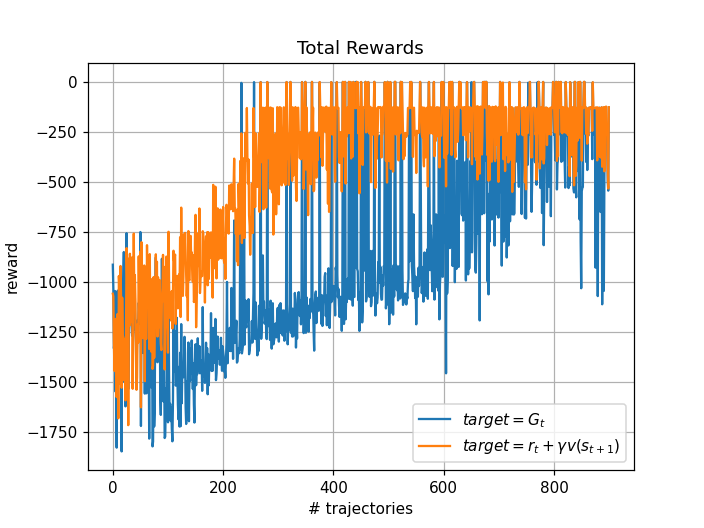

In [15]:
plt.plot(total_rewards, label = r'$target = G_t$')
plt.plot(total_rewards_1, label = r'$target = r_t+\gamma v(s_{t+1})$')
plt.title('Total Rewards')
plt.legend()
plt.ylabel('reward')
plt.xlabel('# trajectories')
plt.grid()
plt.show()

In [16]:
plt.savefig('chubar6_1.png',dpi=300, bbox_inches='tight', facecolor='w')

In [148]:
state = env.reset()
total_reward = 0
for t in range(200):
    states.append(state)
    action = agent.get_action(state,1)
    actions.append(action)

    state, reward, done, _ = env.step(2 * action)
    rewards.append(reward)
    dones.append(done)
    env.render()
    total_reward += reward
print(total_reward)

-129.06205155305108


tensor(1.)

class PPO_0(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=1e-4):

        super().__init__()
        
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh()).to(self.device)
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1)).to(self.device)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state, rand_factor = 1):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, rand_factor*torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        states, actions, returns = states.to(self.device), actions.to(self.device), returns.to(self.device)

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()